# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# Identify missing or unknown data values and convert them to NaNs.
for c in azdias.columns:
    missing_string = feat_info.loc[feat_info.attribute == c, 'missing_or_unknown'].iloc[0]
    missing_list = missing_string[1:-1].split(',')
    azdias[c].replace(missing_list, np.nan, inplace=True)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_counts = dict()
for c in azdias.columns:
    missing_counts[c] = azdias[c].isnull().sum()

42
['KK_KUNDENTYP']
584612


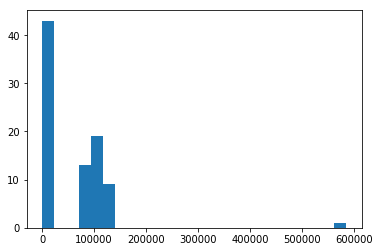

In [7]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_counts.values(), bins=25)

lot_missing_columns = [k for (k,v) in missing_counts.items() if v > 50000]
print(len(lot_missing_columns))

outlier_columns = [k for (k,v) in missing_counts.items() if v / len(azdias) > 0.15]
print(outlier_columns)
print(missing_counts[outlier_columns[0]])

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(outlier_columns, axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

About half of the columns (42) were missing more than 50,000 entries, clustered in the range of 50,000 to 150,000 missing entries. That's approximately 5-16% of the data. One column ('KK_KUNDENTYP') was missing 584,612 entries, over 60% of the data! This column has been dropped from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

(array([  7.25800000e+05,   1.76400000e+04,   5.38000000e+02,
          1.60860000e+04,   5.70500000e+03,   1.72860000e+04,
          7.79000000e+02,   3.08900000e+03,   6.67200000e+03,
          2.30100000e+03,   8.20000000e+02,   1.20600000e+03,
          4.30000000e+01,   3.80000000e+01,   3.60000000e+01,
          2.20000000e+01,   1.20000000e+01,   0.00000000e+00,
          1.91640000e+04,   3.85000000e+02,   0.00000000e+00,
          0.00000000e+00,   7.34990000e+04,   0.00000000e+00,
          1.00000000e+02]),
 array([  0. ,   1.8,   3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,
         16.2,  18. ,  19.8,  21.6,  23.4,  25.2,  27. ,  28.8,  30.6,
         32.4,  34.2,  36. ,  37.8,  39.6,  41.4,  43.2,  45. ]),
 <a list of 25 Patch objects>)

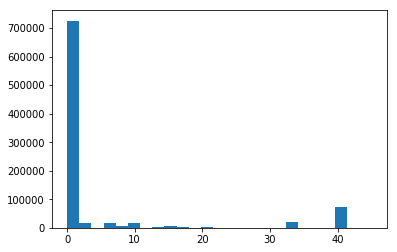

In [9]:
# How much data is missing in each row of the dataset?
num_cols = len(azdias.columns)
missing_counts_by_row = azdias.apply(lambda x: num_cols - x.count(), axis=1)

plt.hist(missing_counts_by_row, bins=25)

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 5
azdias_outliers = azdias.loc[missing_counts_by_row.values > threshold, :]
azdias_rest = azdias.loc[missing_counts_by_row.values <= threshold, :]

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_sets(data_outliers, data_rest, columns):
    f, axes = plt.subplots(len(columns), 2, figsize=(6,(4 * (len(columns) + 1))))
    for i in range(len(columns)):
        sns.countplot(x=columns[i], data=data_outliers, ax=axes[i][0])
        sns.countplot(x=columns[i], data=data_rest, ax=axes[i][1])

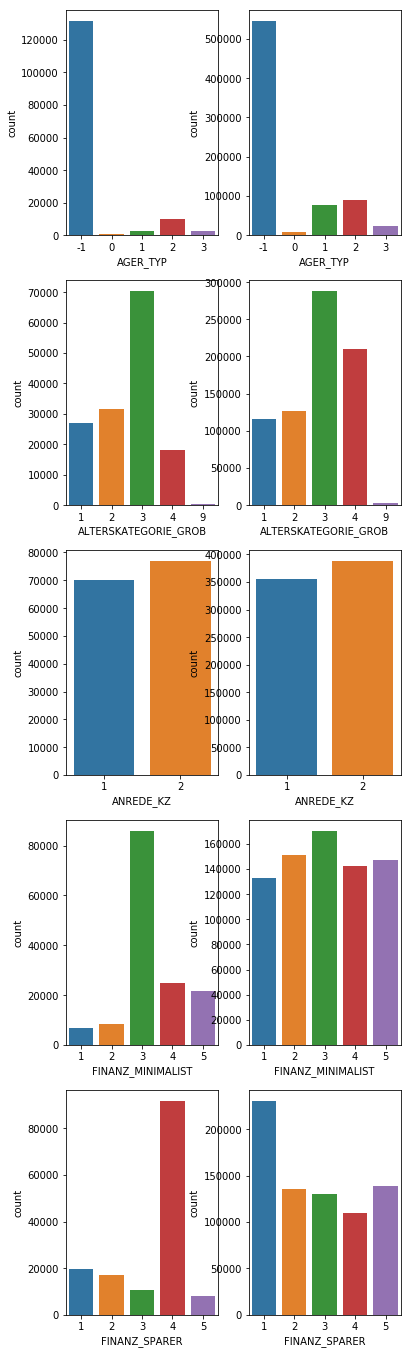

In [12]:
none_missing_columns = [k for (k,v) in missing_counts.items() if v == 0]
sample_cols = none_missing_columns[0:5]

compare_sets(azdias_outliers, azdias_rest, sample_cols)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The distribution of data is similar between the rows with a lot of missing data and the rows with very little missing data for certain columns, such as ANREDE_KZ, AGER_TYP, and to a lesser degree ALTERSKATEGORIE_GROB. On the other hand, the distribution between the two datasets is *quite* different for some columns, such as FINANZ_SPARER and FINANZ_MINIMALIST. Depending on the meaning of these columns, this could have implications for our analysis by dropping the rows with lots of missing data. These rows could come from a different data source with more missing values but also representing a different segment of the population.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [13]:
# How many features are there of each data type?
cat_features = feat_info[feat_info.type == 'categorical']['attribute'].tolist()
mix_features = feat_info[feat_info.type == 'mixed']['attribute'].tolist()

# Ensure we aren't counting features which have been removed already
cat_features = list(set(cat_features) - set(outlier_columns))
mix_features = list(set(mix_features) - set(outlier_columns))

print('There are {} categorical features'.format(len(cat_features)))
print('There are {} mixed features'.format(len(mix_features)))

There are 20 categorical features
There are 7 mixed features


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [14]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
do_nothing_list = []
create_dummies_list = []
multi_dummies_or_drop_list = []
for cat_feature in cat_features:
    if len(azdias_rest[cat_feature].unique()) <= 2:
        if pd.api.types.is_numeric_dtype(azdias_rest[cat_feature]):
            do_nothing_list.append(cat_feature)
        else:
            create_dummies_list.append(cat_feature)
    else:
        multi_dummies_or_drop_list.append(cat_feature)
        
print(do_nothing_list)
print(create_dummies_list)
print(multi_dummies_or_drop_list)

['SOHO_KZ', 'ANREDE_KZ', 'GREEN_AVANTGARDE']
['OST_WEST_KZ']
['FINANZTYP', 'VERS_TYP', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP', 'AGER_TYP', 'TITEL_KZ', 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP', 'NATIONALITAET_KZ', 'GEBAEUDETYP']


In [15]:
print(azdias_rest['OST_WEST_KZ'].unique())
print(len(multi_dummies_or_drop_list))

['W' 'O']
16


In [16]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_rest['OST_WEST_KZ'] = azdias_rest['OST_WEST_KZ'].apply(lambda x: 0 if x == 'O'
                                                                   else 1 if x == 'W'
                                                                   else x)
print(azdias_rest['OST_WEST_KZ'].unique())

[1 0]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# Drop multi-categorical features
azdias_rest.drop(multi_dummies_or_drop_list, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Discussion 1.2.1: Re-Encode Categorical Features

I found three features with numeric, binary features ('ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ'), with which I did nothing. I found one feature with non-numeric binary features ('OST_WEST_KZ', with values 'O' and 'W'), which I re-encoded with '0' for 'O' and '1' for 'W'. I found 16 features which were multi-level categoricals ('AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'), and chose to drop these from my analysis for the time being to keep the number of features down. If I have more time later, I can come back and re-encode these using OneHotEncoder and see how this changes my results.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [18]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream_list = [1,3,5,8,10,12,14]
avantgarde_list = [2,4,6,7,9,11,13,15]

decade_40s = [1,2]
decade_50s = [3,4]
decade_60s = [5,6,7]
decade_70s = [8,9]
decade_80s = [10,11,12,13]
decade_90s = [14,15]

azdias_rest['AVANTGARDE_MAINSTREAM'] = \
    azdias_rest['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in avantgarde_list
                                                    else 2 if x in mainstream_list
                                                    else 0)
    
azdias_rest['DECADE'] = \
    azdias_rest['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 40 if x in decade_40s
                                                    else 50 if x in decade_50s
                                                    else 60 if x in decade_60s
                                                    else 70 if x in decade_70s
                                                    else 80 if x in decade_80s
                                                    else 90 if x in decade_90s
                                                    else 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [19]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(azdias_rest['CAMEO_INTL_2015'].unique())

azdias_rest['WEALTH'] = \
    azdias_rest['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else x)
    
azdias_rest['LIFESTAGE'] = \
    azdias_rest['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else x)

print(azdias_rest['WEALTH'].unique())
print(azdias_rest['LIFESTAGE'].unique())

['51' '24' '12' '43' '54' '22' '14' '13' '15' '41' '34' '55' '33' '25' nan
 '23' '31' '52' '35' '45' '44' '32']


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


['5' '2' '1' '4' '3' nan]
['1' '4' '2' '3' '5' nan]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Discussion 1.2.2: Engineer Mixed-Type Features

I performed re-engineering on the features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'. I re-encoded 'PRAEGENDE_JUGENDJAHRE' into two features: 'AVANTGARDE_MAINSTREAM' and 'DECADE', dropping information about east vs. west. I re-encoded 'CAMEO_INTL_2015' into two features: 'WEALTH' and 'LIFESTAGE'.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [20]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_rest.drop(mix_features, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [21]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    outlier_columns = ['KK_KUNDENTYP']
    threshold_row = 5
    
    cat_features_to_drop= ['LP_FAMILIE_FEIN',
                           'LP_STATUS_GROB', 'FINANZTYP',
                           'CAMEO_DEUG_2015', 'GEBAEUDETYP',
                           'GFK_URLAUBERTYP', 'CAMEO_DEU_2015',
                           'LP_FAMILIE_GROB', 'TITEL_KZ',
                           'CJT_GESAMTTYP', 'LP_STATUS_FEIN',
                           'ZABEOTYP', 'SHOPPER_TYP', 'VERS_TYP',
                           'AGER_TYP', 'NATIONALITAET_KZ']
    
    mix_features_to_drop = ['WOHNLAGE', 'KBA05_BAUMAX',
                            'LP_LEBENSPHASE_FEIN', 'PLZ8_BAUMAX',
                            'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015',
                            'LP_LEBENSPHASE_GROB']
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for c in df.columns:
        missing_string = feat_info.loc[feat_info.attribute == c, 'missing_or_unknown'].iloc[0]
        missing_list = missing_string[1:-1].split(',')
        df[c] = df[c].replace(missing_list, np.nan)
    
    # remove selected columns and rows, ...=
    df = df.drop(outlier_columns, axis=1)
    
    num_cols = len(df.columns)
    missing_counts_by_row = df.apply(lambda x: num_cols - x.count(), axis=1)
    df = df.loc[missing_counts_by_row.values <= threshold_row, :]
    
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].apply(lambda x: 0 if x == 'O'
                                                     else 1 if x == 'W'
                                                     else x)
    
    df = df.drop(cat_features_to_drop, axis=1)
    
    mainstream_list = [1,3,5,8,10,12,14]
    avantgarde_list = [2,4,6,7,9,11,13,15]

    decade_40s = [1,2]
    decade_50s = [3,4]
    decade_60s = [5,6,7]
    decade_70s = [8,9]
    decade_80s = [10,11,12,13]
    decade_90s = [14,15]

    df['AVANTGARDE_MAINSTREAM'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in avantgarde_list
                                                                         else 2 if x in mainstream_list
                                                                         else 0)

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 40 if x in decade_40s
                                                          else 50 if x in decade_50s
                                                          else 60 if x in decade_60s
                                                          else 70 if x in decade_70s
                                                          else 80 if x in decade_80s
                                                          else 90 if x in decade_90s
                                                          else 0)

    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if not pd.isnull(x) else x)
    df['LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if not pd.isnull(x) else x)
    
    df = df.drop(mix_features_to_drop, axis=1)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [22]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer()
azdias_imputed = imp.fit_transform(azdias_rest)
azdias_imputed_df = pd.DataFrame(azdias_imputed, columns = azdias_rest.columns)

In [23]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)
azdias_scaled_df = pd.DataFrame(azdias_scaled, columns = azdias_rest.columns)

### Discussion 2.1: Apply Feature Scaling

As a first basic implementation, I have used an Imputer with default parameters to replace NaN (missing) values with the mean by each column. I have then used a StandardScaler to determine the mean and standard deviation of the dataset by feature and rescale features so each has mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [24]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled_df)

Cumulative variance explained with 40 components: 0.9335736504154213


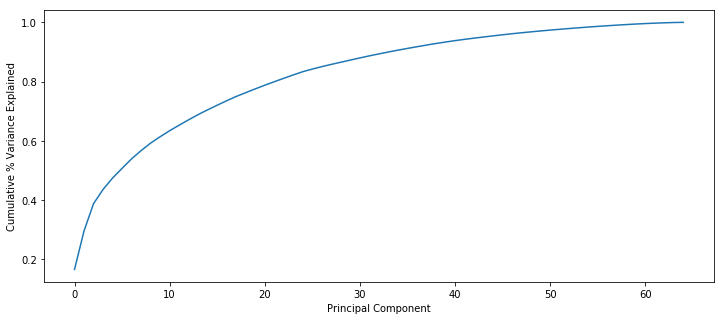

In [25]:
# Investigate the variance accounted for by each principal component.
num_components = len(pca.explained_variance_ratio_)
indices = np.arange(num_components)
explained_variances = pca.explained_variance_ratio_

plt.figure(figsize=(12, 5))
cumulative_variances = np.cumsum(explained_variances)
plt.plot(indices, cumulative_variances)

plt.xlabel("Principal Component")
plt.ylabel("Cumulative % Variance Explained")

print('Cumulative variance explained with 40 components: {}'.format(cumulative_variances[39]))

In [26]:
# Re-apply PCA to the data while selecting for number of components to retain.
reduced_components = 40
reduced_pca = PCA(reduced_components)
azdias_reduced_pca = reduced_pca.fit_transform(azdias_scaled_df)

### Discussion 2.2: Perform Dimensionality Reduction

I have found that it requires 40 principal components to retain approximately 90% of the cumulative explained variance. Since there is no obvious sharp drop-off point after which very little additional variance is explained, I will start with these 40 components. It is possible that not much benefit is gained by using a reduced number principal components, and we would be better off using all of the components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [27]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_pca_weights(component_num, pca, data):
    components = pd.DataFrame(np.round(pca.components_, 4),
                              columns = data.keys()).sort_values(by=component_num - 1, axis=1)
    print(components.iloc[component_num - 1])

print_pca_weights(1, reduced_pca, azdias_scaled_df)

MOBI_REGIO              -0.2499
PLZ8_ANTG1              -0.2336
KBA05_ANTG1             -0.2321
KBA05_GBZ               -0.2248
FINANZ_MINIMALIST       -0.2113
PLZ8_GBZ                -0.1740
KONSUMNAEHE             -0.1729
INNENSTADT              -0.1710
BALLRAUM                -0.1323
LIFESTAGE               -0.1253
GEBAEUDETYP_RASTER      -0.1199
GREEN_AVANTGARDE        -0.1078
FINANZ_VORSORGER        -0.0973
ALTERSKATEGORIE_GROB    -0.0944
ANZ_PERSONEN            -0.0826
KBA13_ANZAHL_PKW        -0.0824
SEMIO_LUST              -0.0637
SEMIO_ERL               -0.0637
MIN_GEBAEUDEJAHR        -0.0601
WOHNDAUER_2008          -0.0578
OST_WEST_KZ             -0.0560
ONLINE_AFFINITAET       -0.0542
SEMIO_VERT              -0.0383
ALTER_HH                -0.0257
GEBURTSJAHR             -0.0244
RETOURTYP_BK_S          -0.0053
HEALTH_TYP              -0.0052
ANZ_TITEL               -0.0035
SOHO_KZ                 -0.0021
KBA05_ANTG2              0.0088
                          ...  
SEMIO_SO

In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(2, reduced_pca, azdias_scaled_df)

SEMIO_REL               -0.2643
FINANZ_SPARER           -0.2408
SEMIO_TRADV             -0.2405
SEMIO_PFLICHT           -0.2367
SEMIO_KULT              -0.2357
FINANZ_UNAUFFAELLIGER   -0.2250
DECADE                  -0.2140
FINANZ_ANLEGER          -0.2015
SEMIO_FAM               -0.1965
SEMIO_RAT               -0.1722
SEMIO_MAT               -0.1706
ONLINE_AFFINITAET       -0.1662
SEMIO_SOZ               -0.1171
ALTER_HH                -0.1033
SEMIO_VERT              -0.0780
KBA05_GBZ               -0.0705
MOBI_REGIO              -0.0688
PLZ8_ANTG1              -0.0687
GEBURTSJAHR             -0.0606
KBA05_ANTG1             -0.0597
INNENSTADT              -0.0585
ANZ_PERSONEN            -0.0580
PLZ8_GBZ                -0.0549
KONSUMNAEHE             -0.0523
HEALTH_TYP              -0.0504
BALLRAUM                -0.0484
MIN_GEBAEUDEJAHR        -0.0375
GEBAEUDETYP_RASTER      -0.0319
KBA13_ANZAHL_PKW        -0.0275
AVANTGARDE_MAINSTREAM   -0.0214
                          ...  
PLZ8_HHZ

In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_pca_weights(3, reduced_pca, azdias_scaled_df)

ANREDE_KZ               -0.3682
SEMIO_KAEM              -0.3372
SEMIO_DOM               -0.3143
SEMIO_KRIT              -0.2662
SEMIO_RAT               -0.2289
FINANZ_ANLEGER          -0.1964
SEMIO_ERL               -0.1612
FINANZ_SPARER           -0.1177
FINANZ_UNAUFFAELLIGER   -0.1089
SEMIO_PFLICHT           -0.0934
SEMIO_TRADV             -0.0932
DECADE                  -0.0779
ONLINE_AFFINITAET       -0.0648
FINANZ_HAUSBAUER        -0.0469
PLZ8_ANTG1              -0.0430
INNENSTADT              -0.0396
ALTER_HH                -0.0393
PLZ8_GBZ                -0.0371
KONSUMNAEHE             -0.0345
GEBURTSJAHR             -0.0335
BALLRAUM                -0.0318
MOBI_REGIO              -0.0287
GEBAEUDETYP_RASTER      -0.0279
KBA05_GBZ               -0.0265
AVANTGARDE_MAINSTREAM   -0.0258
KBA13_ANZAHL_PKW        -0.0229
KBA05_ANTG1             -0.0223
HH_EINKOMMEN_SCORE      -0.0208
OST_WEST_KZ             -0.0147
MIN_GEBAEUDEJAHR        -0.0133
                          ...  
PLZ8_HHZ

### Discussion 2.3: Interpret Principal Components

The first feature (with highest explained variance) seems to be associated with wealth, net worth, and number of large (6-10 person) households. It is negatively associated with small (1-2 person) households.

The second feature appears to be associated with older, more religious, less event-oriented individuals who save money.

The third feature represents individuals who are more critical, rational, dominant, and combative, and who are less family-oriented, culturally and socially minded, or dreamful. This feature is also associated with the male gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [28]:
# Over a number of different cluster counts...
avg_dist = np.zeros(19)
for k in range(2,21):

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters = k).fit(azdias_reduced_pca)
    
    # compute the average within-cluster distances.
    avg_dist[k - 2] = -1 * kmeans.score(azdias_reduced_pca)
    print('With {} clusters, average distance is {}.'.format(k, avg_dist[k - 2]))

With 2 clusters, average distance is 39056174.854835756.
With 3 clusters, average distance is 36069365.444104664.
With 4 clusters, average distance is 34222922.50884786.
With 5 clusters, average distance is 32831379.624823004.
With 6 clusters, average distance is 31661034.070532247.
With 7 clusters, average distance is 30605876.61116581.
With 8 clusters, average distance is 29765899.26236801.
With 9 clusters, average distance is 28982388.72676288.
With 10 clusters, average distance is 28267671.77599231.
With 11 clusters, average distance is 28053202.75961291.
With 12 clusters, average distance is 27409701.6421935.
With 13 clusters, average distance is 27333059.046654858.
With 14 clusters, average distance is 26714193.594156176.
With 15 clusters, average distance is 26036636.118161254.
With 16 clusters, average distance is 26115024.575403523.
With 17 clusters, average distance is 25866645.856239792.
With 18 clusters, average distance is 25304395.012979478.
With 19 clusters, average dist

In [29]:
print('Best number of clusters is {}, with average distance {}.'.format(np.argmin(avg_dist) + 2, min(avg_dist)))

Best number of clusters is 20, with average distance 24712500.446392674.


Average distance with 20 clusters: 24712500.446392674


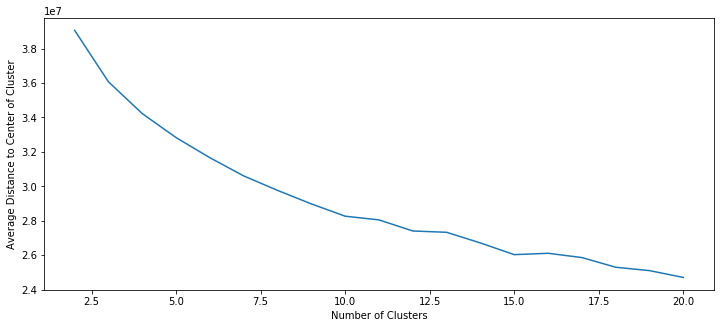

In [30]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
clusters_range = len(avg_dist)
indices = range(2, clusters_range + 2)

plt.figure(figsize=(12, 5))
plt.plot(indices, avg_dist)

plt.xlabel("Number of Clusters")
plt.ylabel("Average Distance to Center of Cluster")

print('Average distance with {} clusters: {}'.format(np.argmin(avg_dist) + 2, min(avg_dist)))

In [36]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = np.argmin(avg_dist) + 2).fit(azdias_reduced_pca)
labels_azdias = kmeans.predict(azdias_reduced_pca)

### Discussion 3.1: Apply Clustering to General Population

I found that the average distance to the center of the cluster decreased pretty consistently as the number of clusters increased, all the way to 20 clusters (which is where I stopped). Consequently, I have decided to proceed with 20 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [32]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [37]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)

customers_imputed = imp.transform(customers_cleaned)
customers_imputed_df = pd.DataFrame(customers_imputed, columns = customers_cleaned.columns)

customers_scaled = scaler.transform(customers_imputed)
customers_scaled_df = pd.DataFrame(customers_scaled, columns = customers_cleaned.columns)

customers_pca = reduced_pca.transform(customers_scaled_df)

kmeans = KMeans(n_clusters = 20).fit(customers_pca)
labels_customer = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

(0, 25)

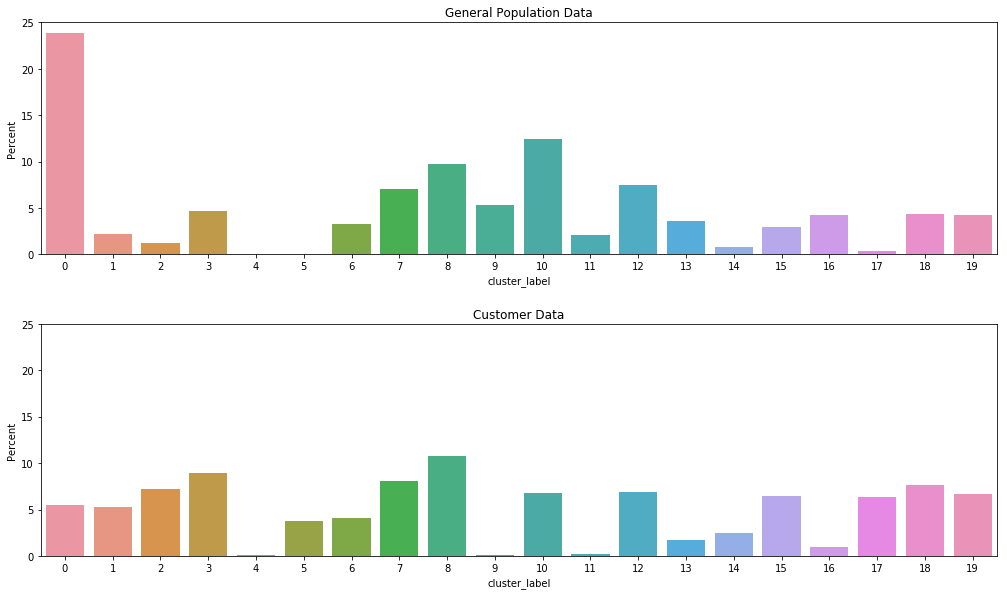

In [64]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_clusters_df = pd.DataFrame(labels_azdias, columns=['cluster_label'])
customers_clusters_df = pd.DataFrame(labels_customer, columns=['cluster_label'])

f, axes = plt.subplots(2, 1, figsize=(14,8))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

sns.barplot(x="cluster_label", y="cluster_label", data=azdias_clusters_df,
            estimator=lambda x: len(x) / len(azdias_clusters_df) * 100,
            ax = axes[0])
axes[0].set(ylabel="Percent")
axes[0].set_title('General Population Data')
axes[0].set_ylim(0,25)

sns.barplot(x="cluster_label", y="cluster_label", data=customers_clusters_df,
            estimator=lambda x: len(x) / len(customers_clusters_df) * 100,
            ax = axes[1])
axes[1].set(ylabel="Percent")
axes[1].set_title('Customer Data')
axes[1].set_ylim(0,25)

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

print('One cluster which is overrepresented in the customer data is cluster 17.')
print(' ')

centroid17 = pd.DataFrame(kmeans.cluster_centers_[17], columns=['component_values'])
centroid17 = centroid17.sort_values('component_values')

largest_neg = centroid17.head(1).index.values[0]
largest_pos = centroid17.tail(1).index.values[0]

print('The PCA component with largest positive association with cluster 17 is component #{}.'.format(largest_pos))
print('The PCA component with largest negative association with cluster 17 is component #{}.'.format(largest_neg))

One cluster which is overrepresented in the customer data is cluster 17.
 
The PCA component with largest positive association with cluster 17 is component #2.
The PCA component with largest negative association with cluster 17 is component #0.


In [86]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

print('One cluster which is underrepresented in the customer data is cluster 0.')
print(' ')

centroid0 = pd.DataFrame(kmeans.cluster_centers_[0], columns=['component_values'])
centroid0 = centroid0.sort_values('component_values')

largest_neg = centroid0.head(1).index.values[0]
largest_pos = centroid0.tail(1).index.values[0]

print('The PCA component with largest positive association with cluster 0 is component #{}.'.format(largest_pos))
print('The PCA component with largest negative association with cluster 0 is component #{}.'.format(largest_neg))

One cluster which is underrepresented in the customer data is cluster 0.
 
The PCA component with largest positive association with cluster 0 is component #1.
The PCA component with largest negative association with cluster 0 is component #0.


### Discussion 3.3: Compare Customer Data to Demographics Data

We have found that cluster number 17 (the 18th cluster) is overrepresented in the customer data relative to the general population. We have also found that this cluster is positively associated with PCA component number 2 (which is the third component) and negatively associated with PCA component number 0 (the first component). From our interpretations above, we know that the first component is associated with wealthier individuals in areas with large houses. The third component is associated with rational, critical individuals who tend to be male and not particularly idealistic. Consequently, we can conclude that highly rational, critical, non-idealistic individuals (who measure high in the third component), but who are not as likely to be wealthy (the first component) are more highly represented in the customer data than the general population, and therefore are a potential target audience.

We have also found that cluster number 0 (the first cluster) is *under*represented in the customer data. This cluster is positively associated with the second PCA component, which was found to be associated with older, religious individuals who tend to save money. This cluster is also negatively associated with the 1st component, representing high-wealth individuals. Consequently, the individuals who are older, religious, and tend to save money (second PCA component), but are not necessarily particularly wealthy (first component) are *less* likely to be a relevant target audience for this company.

Simple high-level takeaways of this analysis:

1) Individuals who are highly rational, critical, non-idealistic, not very social or culturally minded, potentially combative or dominant and likely male are a strong target audience for this company.

2) Individuals who are older, less event-focused, religious-minded and who tend to save money would be a poor target audience for this company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.